# Learning Curves: Exploring the Bias-Variance Tradeoff

In practice, much of the task of machine learning involves selecting algorithms,
parameters, and sets of data to optimize the results of the method. All of these
things can affect the quality of the results, but it’s not always clear which is
best. For example, if your results have an error that’s larger than you hoped,
you might imagine that increasing the training set size will always lead to better
results. But this is not the case! Below, we’ll explore the reasons for this.
Much of the material in this section was adapted from Andrew Ng’s excellent set
of machine learning video lectures. See http://www.ml-class.org.

In this section we’ll work with an extremely simple learning model: polynomial
regression. This simply fits a polynomial of degree d to the data: if d = 1,
then it is simple linear regression.
First we'll ensure that we're in pylab mode, with figures being displayed inline:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Polynomial regression can be done with the functions ``polyfit``
and ``polyval``, available in ``numpy``. For example:

In [2]:
import numpy as np
np.random.seed(42)
x = np.random.random(20)
y = np.sin(2 * x)
p = np.polyfit(x, y, 1)  # fit a 1st-degree polynomial (i.e. a line) to the data
print p  # slope and intercept

[ 0.97896174  0.20367395]


In [3]:
x_new = np.random.random(3)
y_new = np.polyval(p, x_new)  # evaluate the polynomial at x_new
print abs(np.sin(x_new) - y_new)

[ 0.22826933  0.20119119  0.20166572]


Using a 1st-degree polynomial fit (that is, fitting a straight line to x and y),
we predicted the value of y for a new input. This prediction has an absolute
error of about 0.2 for the few test points which we tried. We can visualize
the fit with the following function:

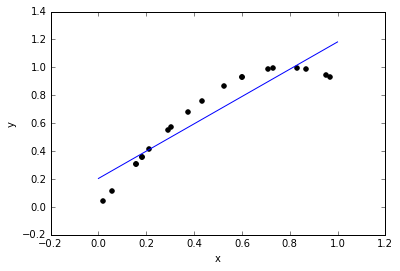

In [4]:
import pylab as pl
def plot_fit(x, y, p):
    xfit = np.linspace(0, 1, 1000)
    yfit = np.polyval(p, xfit)
    pl.scatter(x, y, c='k')
    pl.plot(xfit, yfit)
    pl.xlabel('x')
    pl.ylabel('y')
    
plot_fit(x, y, p)

When the error of predicted results is larger than desired,
there are a few courses of action that can be taken:

1. Increase the number of training points N. This might give us a
   training set with more coverage, and lead to greater accuracy.
2. Increase the degree d of the polynomial. This might allow us to
   more closely fit the training data, and lead to a better result
3. Add more features. If we were to, for example, perform a linear
   regression using $x$, $\sqrt{x}$, $x^{-1}$, or other functions, we might
   hit on a functional form which can better be mapped to the value of y.

The best course to take will vary from situation to situation, and from
problem to problem. In this situation, number 2 and 3 may be useful, but
number 1 will certainly not help: our model does not intrinsically fit the
data very well. In machine learning terms, we say that it has high bias
and that the data is *under-fit*. The ability to quickly figure out how
to tune and improve your model is what separates good machine learning
practitioners from the bad ones. In this section we’ll discuss some tools
that can help determine which course is most likely to lead to good results.

## Bias, Variance, Overfitting, and Underfitting

We’ll work with a simple example. Imagine that you would like to build
an algorithm which will predict the price of a house given its size.
Naively, we’d expect that the cost of a house grows as the size increases,
but there are many other factors which can contribute. Imagine we approach
this problem with the polynomial regression discussed above. We can tune
the degree $d$ to try to get the best fit.

First let's define some utility functions:

In [5]:
def test_func(x, err=0.5):
    return np.random.normal(10 - 1. / (x + 0.1), err)

def compute_error(x, y, p):
    yfit = np.polyval(p, x)
    return np.sqrt(np.mean((y - yfit) ** 2))

Run the following code to produce an example plot:

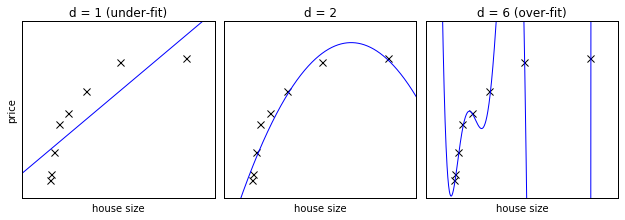

In [6]:
N = 8
np.random.seed(42)
x = 10 ** np.linspace(-2, 0, N)
y = test_func(x)

xfit = np.linspace(-0.2, 1.2, 1000)

titles = ['d = 1 (under-fit)', 'd = 2', 'd = 6 (over-fit)']
degrees = [1, 2, 6]

pl.figure(figsize = (9, 3.5))
pl.subplots_adjust(left = 0.06, right=0.98,
                   bottom=0.15, top=0.85,
                   wspace=0.05)
for i, d in enumerate(degrees):
    pl.subplot(131 + i, xticks=[], yticks=[])
    pl.scatter(x, y, marker='x', c='k', s=50)

    p = np.polyfit(x, y, d)
    yfit = np.polyval(p, xfit)
    pl.plot(xfit, yfit, '-b')
    
    pl.xlim(-0.2, 1.2)
    pl.ylim(0, 12)
    pl.xlabel('house size')
    if i == 0:
        pl.ylabel('price')

    pl.title(titles[i])

In the above figure, we see fits for three different values of $d$.
For $d = 1$, the data is under-fit. This means that the model is too
simplistic: no straight line will ever be a good fit to this data. In
this case, we say that the model suffers from high bias. The model
itself is biased, and this will be reflected in the fact that the data
is poorly fit. At the other extreme, for $d = 6$ the data is over-fit.
This means that the model has too many free parameters (6 in this case)
which can be adjusted to perfectly fit the training data. If we add a
new point to this plot, though, chances are it will be very far from
the curve representing the degree-6 fit. In this case, we say that the
model suffers from high variance. The reason for this label is that if
any of the input points are varied slightly, it could result in an
extremely different model.

In the middle, for $d = 2$, we have found a good mid-point. It fits
the data fairly well, and does not suffer from the bias and variance
problems seen in the figures on either side. What we would like is a
way to quantitatively identify bias and variance, and optimize the
metaparameters (in this case, the polynomial degree d) in order to
determine the best algorithm. This can be done through a process
called cross-validation.

## Cross-validation and Testing

Let's start by defining a new dataset which we can use to explore
cross-validation.  We will use a simple x vs. y regression estimator
for ease of visualization, but the concepts also readily apply to
more complicated datasets and models.

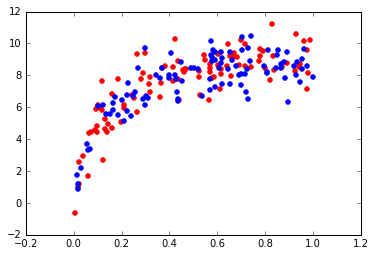

In [7]:
Ntrain = 100
Ncrossval = 100
Ntest = 50
error = 1.0

# randomly sample the data
np.random.seed(0)
x = np.random.random(Ntrain + Ncrossval + Ntest)
y = test_func(x, error)

# select training set
# data is already random, so we can just choose a slice.
xtrain = x[:Ntrain]
ytrain = y[:Ntrain]

# select cross-validation set
xcrossval = x[Ntrain:Ntrain + Ncrossval]
ycrossval = y[Ntrain:Ntrain + Ncrossval]

# select test set
xtest = x[Ntrain:-Ntest]
ytest = y[Ntrain:-Ntest]

pl.scatter(xtrain, ytrain, color='red')
pl.scatter(xcrossval, ycrossval, color='blue')

In order to quantify the effects of bias and variance and construct
the best possible estimator, we will split our training data into
three parts: a *training set*, a *cross-validation set*, and a
*test set*. As a general rule, the training set should be about
60% of the samples, and the cross-validation and test sets should
be about 20% each.

The general idea is as follows. The model parameters (in our case,
the coefficients of the polynomials) are learned using the training
set as above. The error is evaluated on the cross-validation set,
and the meta-parameters (in our case, the degree of the polynomial)
are adjusted so that this cross-validation error is minimized.
Finally, the labels are predicted for the test set. These labels
are used to evaluate how well the algorithm can be expected to
perform on unlabeled data.

Why do we need both a cross-validation set and a test set? Many
machine learning practitioners use the same set of data as both
a cross-validation set and a test set. This is not the best approach,
for the same reasons we outlined above. Just as the parameters can
be over-fit to the training data, the meta-parameters can be over-fit
to the cross-validation data. For this reason, the minimal
cross-validation error tends to under-estimate the error expected
on a new set of data.

The cross-validation error of our polynomial classifier can be visualized by plotting the error as a function of the polynomial degree d. We can do this as follows.  This will spit out warnings about "poorly conditioned" polynomials: that is OK for now.

/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


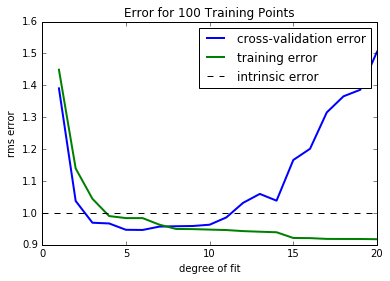

In [8]:
degrees = np.arange(1, 21)
train_err = np.zeros(len(degrees))
crossval_err = np.zeros(len(degrees))
test_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(xtrain, ytrain, d)

    train_err[i] = compute_error(xtrain, ytrain, p)
    crossval_err[i] = compute_error(xcrossval, ycrossval, p)

pl.figure()
pl.title('Error for 100 Training Points')
pl.plot(degrees, crossval_err, lw=2, label = 'cross-validation error')
pl.plot(degrees, train_err, lw=2, label = 'training error')
pl.plot([0, 20], [error, error], '--k', label='intrinsic error')

pl.legend()
pl.xlabel('degree of fit')
pl.ylabel('rms error')

This figure compactly shows the reason that cross-validation is
important. On the left side of the plot, we have very low-degree
polynomial, which under-fits the data. This leads to a very high
error for both the training set and the cross-validation set. On
the far right side of the plot, we have a very high degree
polynomial, which over-fits the data. This can be seen in the fact
that the training error is very low, while the cross-validation
error is very high. Plotted for comparison is the intrinsic error
(this is the scatter artificially added to the data: click on the
above image to see the source code). For this toy dataset,
error = 1.0 is the best we can hope to attain. Choosing $d=6$ in
this case gets us very close to the optimal error.

The astute reader will realize that something is amiss here: in
the above plot, $d = 6$ gives the best results. But in the previous
plot, we found that $d = 6$ vastly over-fits the data. What’s going
on here? The difference is the **number of training points** used.
In the previous example, there were only eight training points.
In this example, we have 100. As a general rule of thumb, the more
training points used, the more complicated model can be used.
But how can you determine for a given model whether more training
points will be helpful? A useful diagnostic for this are learning curves.

## Learning Curves

A learning curve is a plot of the training and cross-validation
error as a function of the number of training points. Note that
when we train on a small subset of the training data, the training
error is computed using this subset, not the full training set.
These plots can give a quantitative view into how beneficial it
will be to add training samples.

In [9]:
# suppress warnings from Polyfit
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

def plot_learning_curve(d):
    sizes = np.linspace(2, Ntrain, 50).astype(int)
    train_err = np.zeros(sizes.shape)
    crossval_err = np.zeros(sizes.shape)

    for i, size in enumerate(sizes):
        p = np.polyfit(xtrain[:size], ytrain[:size], d)
        crossval_err[i] = compute_error(xcrossval, ycrossval, p)
        train_err[i] = compute_error(xtrain[:size], ytrain[:size], p)

    fig = pl.figure()
    pl.plot(sizes, crossval_err, lw=2, label='cross-val error')
    pl.plot(sizes, train_err, lw=2, label='training error')
    pl.plot([0, Ntrain], [error, error], '--k', label='intrinsic error')

    pl.xlabel('traning set size')
    pl.ylabel('rms error')
    
    pl.legend(loc = 0)
    
    pl.ylim(0, 4)
    pl.xlim(0, 99)

    pl.title('d = %i' % d)

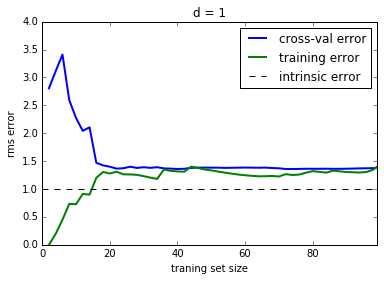

In [10]:
plot_learning_curve(d=1)

Here we show the learning curve for $d = 1$. From the above
discussion, we know that $d = 1$ is a high-bias estimator which
under-fits the data. This is indicated by the fact that both the
training and cross-validation errors are very high. If this is
the case, adding more training data will not help matters: both
lines have converged to a relatively high error.

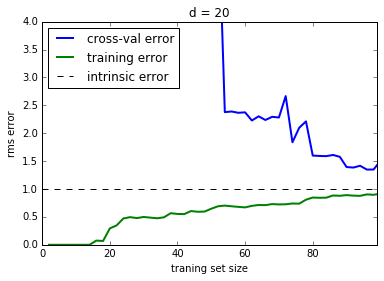

In [11]:
plot_learning_curve(d=20)

Here we show the learning curve for $d = 20$. From the above
discussion, we know that $d = 20$ is a high-variance estimator
which over-fits the data. This is indicated by the fact that the
training error is much less than the cross-validation error. As
we add more samples to this training set, the training error will
continue to climb, while the cross-validation error will continue
to decrease, until they meet in the middle. In this case, our
intrinsic error was set to 1.0, and we can infer that adding more
data will allow the estimator to very closely match the best
possible cross-validation error.

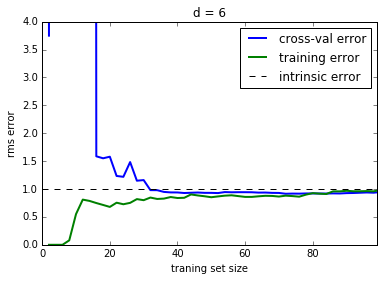

In [12]:
plot_learning_curve(d=6)

For our $d=6$ case, we see that we have more training data than we need.
This is not a problem (especially if the algorithm scales well with large $N$),
but if our data were expensive to obtain or if the training scales unfavorably
with $N$, we could have used a diagram like this to determine this and stop
once we had recorded 40-50 training samples.

## Summary

We’ve seen above that an under-performing algorithm can be due
to two possible situations: high bias (under-fitting) and high
variance (over-fitting). In order to evaluate our algorithm, we
set aside a portion of our training data for cross-validation.
Using the technique of learning curves, we can train on progressively
larger subsets of the data, evaluating the training error and
cross-validation error to determine whether our algorithm has
high variance or high bias. But what do we do with this information?

#### High Bias

If our algorithm shows high bias, the following actions might help:

- **Add more features**. In our example of predicting home prices,
  it may be helpful to make use of information such as the neighborhood
  the house is in, the year the house was built, the size of the lot, etc.
  Adding these features to the training and test sets can improve
  a high-bias estimator
- **Use a more sophisticated model**. Adding complexity to the model can
  help improve on bias. For a polynomial fit, this can be accomplished
  by increasing the degree d. Each learning technique has its own
  methods of adding complexity.
- **Use fewer samples**. Though this will not improve the classification,
  a high-bias algorithm can attain nearly the same error with a smaller
  training sample. For algorithms which are computationally expensive,
  reducing the training sample size can lead to very large improvements
  in speed.
- **Decrease regularization**. Regularization is a technique used to impose
  simplicity in some machine learning models, by adding a penalty term that
  depends on the characteristics of the parameters. If a model has high bias,
  decreasing the effect of regularization can lead to better results.

#### High Variance

If our algorithm shows high variance, the following actions might help:

- **Use fewer features**. Using a feature selection technique may be
  useful, and decrease the over-fitting of the estimator.
- **Use more training samples**. Adding training samples can reduce
  the effect of over-fitting, and lead to improvements in a high
  variance estimator.
- **Increase Regularization**. Regularization is designed to prevent
  over-fitting. In a high-variance model, increasing regularization
  can lead to better results.

These choices become very important in real-world situations. For example,
due to limited telescope time, astronomers must seek a balance between
observing a large number of objects, and observing a large number of
features for each object. Determining which is more important for a
particular learning task can inform the observing strategy that the
astronomer employs. In a later exercise, we will explore the use of
learning curves for the photometric redshift problem.